# UNIVARIATE FORECASTING ON INDONESIA LIVESTOCK PRICE

Using aggregated data from https://hargapangan.id/ from 2016-2020


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,MaxPooling1D,Conv1D,Dropout
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')
tf.__version__

'2.2.0'

In [0]:
# FULL DATA LOADING
df = pd.read_csv('DATA_FULL.csv',index_col = 'Date')
print(f'Length of data : {len(df)}')
df.head()

Length of data : 1429


,Beras,Daging Ayam,Daging Sapi,Telur Ayam,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Minyak Goreng,Gula Pasir
Date,,,,,,,,,,
2016-07-01,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
2016-07-02,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
2016-07-03,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
2016-07-04,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
2016-07-05,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0


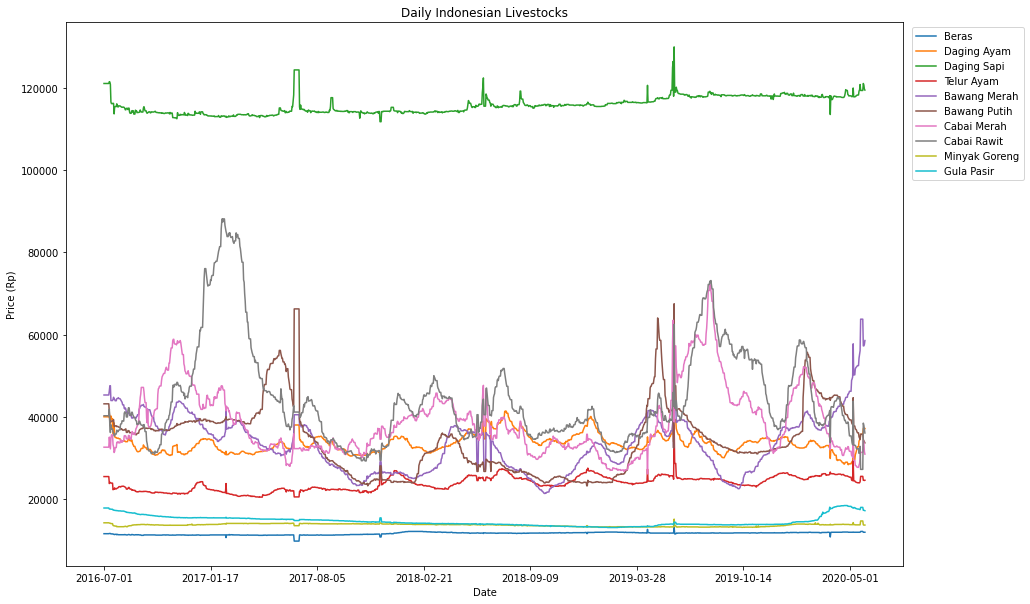

In [0]:
df.plot(figsize=(15,10))
plt.title('Daily Indonesian Livestocks')
plt.ylabel('Price (Rp)')
plt.legend(loc='upper right',bbox_to_anchor=(0.65,0.5,0.5,0.5))

In [0]:
## SELF-BUILT FUNCTION FOR TRAINING UNTIL FORECASTING

def plot_window(data,window):
    """
    Function for plot original data and defined-windowed data.
    data   ---? subset of data taken (in series).
    window ---> Numbers of rolling mean/averaging first data.
    """
    %matplotlib inline
    # Original Plot
    data.plot(figsize=(10,5));plt.title('%s (Original)' %data.name)
    plt.ylabel('Price (Rp)')
    plt.show()
    # Windowed Plot
    data_filt = data.rolling(window).mean().dropna()
    data_filt.plot(figsize=(10,5))
    plt.title('%s (Smoothing by Windowing %d first datum)' %(data.name,window))
    plt.ylabel('Price(Rp)')
    plt.show()
    return data_filt

def train_test_split(data,train_size=0.5):
    """
    Function for split dataset into certain portion of train and test(validation).
    data  --> Full data being splitted.
    """
    train_idx = int(train_size*len(data))
    train,test = data.iloc[:train_idx],data.iloc[train_idx:]
    print(f'Length of Train and Test : {len(train),len(test)}')
    return train,test

def MinMaxScaler(data,Min=None,Max=None):
    """
    Change dataset values into range 0-1 (Scale by reference).
    data  ---> Split data being scaled.
    """
    if Min == None or Max == None:
        Min = data.values.min()
        Max = data.values.max()
    data = (data-Min)/(Max-Min)     
    return data,Min,Max

def scale_val(train,test):
    """
    Change into scaling dataset.
    train,test ---> data after being splitted.(In Series)
    """
    train_scale,Min,Max = MinMaxScaler(train)
    test_scale,Min,Max = MinMaxScaler(test,Min,Max)
    return train_scale,test_scale,Min,Max

def prepare_generator(length,output,train,test):
    """
    MAKE TIMESERIESGENERATOR FOR SEQUENCE(TIME SERIES) CHUNKS.
    RETURN FIRST ARRAY OF TRAIN GENERATOR AND VALIDATION GENERATOR.
    length     ---> number of sequences (batch size every steps in chunks).
    output     ---> number of predicted sequences (n-data after batch size).
    train,test ---> data after being splitted (scaled/original).
    """ 
    train_res,test_res = train.values.reshape(-1,1),test.values.reshape(-1,1)
    generator = TimeseriesGenerator(train_res,train_res,length=length,
                                    batch_size=output)
    validation_generator = TimeseriesGenerator(test_res,test_res,
                                          length=length, batch_size=output) 
    X,y = generator[0]
    XX,yy = validation_generator[0]
    return X,y,XX,yy,generator,validation_generator

def dnn_model(X,output=1,loss='mse',optimizer='adam'):   ## YOU CAN MODIFY IF WANT TO CHANGE DNN ARCHITECTURE
    """
    INITILIAZE NEW MODEL DNN FOR TRAINING.
    model     ---> self-defined model for certain training
    X         ---> train sample return after generated by TimeseriesGenerator (Tensor shape)
    ouput     ---> sequences of output (Univariate = 1, don't change!)
    metric    ---> Cost function used in dnn (default = 'mse').
    optimizer ---> Optimization algorithm in to minimalize cost function (default = 'adam').
    """
    
    #### MODIFY HERE 
    model = Sequential()
    model.add(Conv1D(256,2,activation='relu',input_shape=(X.shape[1],X.shape[2])))
    model.add(MaxPooling1D())
    model.add(Dropout(0.2))
    model.add(LSTM(100,activation='relu',return_sequences=True))
    model.add(LSTM(75,activation='relu',return_sequences=True))
    model.add(Bidirectional(LSTM(50,activation='relu')))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1))
    #### STOP HERE 
    
    model.compile(optimizer=optimizer,loss=loss)
    return model

def train_model(model,train_gen,val_gen,metric='val_loss',wait_order=2,epochs=100):
    """
    TRAIN MODEL WITH EARLY STOPPING
    model             ---> self defined-model created earlier
    train gen,val_gen ---> generator for timeseries created before
    metric            ---> monitor metrics for early stopping (default = 'val_loss').
    wait_order        ---> patience in early stopping after getting arbitrary optimal metric (default = 2).
    epochs            ---> iterations in fitting process (default = 100).
    """
    early_stop = EarlyStopping(monitor=metric,patience=wait_order)
    model.fit(train_gen,epochs=epochs,
                   validation_data = val_gen,
                   callbacks=[early_stop])
    loss = pd.DataFrame(model.history.history)
    return model,loss
    
def plot_loss(dataframe):
    """
    PLOT LOSS HISTORY FROM MODEL TRAINING
    dataframe ---> loss dataframe 
    """
    dataframe.plot(figsize=(10,5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Fitting Loss')
    plt.show()
    
def MAE(y_true,y_pred):
    """
    CALCULATE MEAN ABSOLUTE ERROR BETWEEN PREDICTION AND TRUE VALUES
    y_true ---> test/validation set (in forms of Series/DataFrame/Arrays)
    y_pred ---> prediction set (in forms of Series/DataFrame/Arrays)
    """
    error = np.mean(abs(y_pred-y_true))
    return error
        
def pred_val(length,model,test_data,train_data,Min,Max,n_features=1):
    """
    PREDICT ON VALIDATION/TEST SET
    length     ---> number of moving sequences when predicting values.
    model      ---> trained model
    test_data  ---> test dataset for validation process.
    train_data ---> train dataset for extraction (n-length in last data).
    Min        ---> Minimum range value for invert scaling
    Max        ---> Maximum range value for invert scaling
    n_features ---> dimensionality of univariate process (default = 1, don't change!).
    """
    test_prediction = []    #List for collecting predicted values in validation
    first_eval_batch = train_data[-length:].values   #Last n-length train data 
    current_batch = first_eval_batch.reshape(1,length,n_features) #reshape the batch

    # Prediction
    for i in range(len(test_data)):
    #get prediction one time stamp ahead ([0] is for grabbing just the number in tensor array)
        current_pred = model.predict(current_batch)[0]
    #store prediction
        test_prediction.append(current_pred[0])
    #update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    #Make timestamps for forecasting result
    day = pd.date_range(start=train_data.index[-1],periods=len(test_data)+1).strftime('%Y-%m-%d') 

    # Invert Scale of Predicted Values
    test_pred = []
    test_real = []
    for i in range(len(test_prediction)):
        a = (test_prediction[i]*(Max-Min))+Min
        b = (test_data[i]*(Max-Min))+Min
        test_pred.append(a)
        test_real.append(b)
        
    # Calculate the Error (MAE) and Plot Prediction Result
    prediction = pd.DataFrame(data=test_pred,index=day[1:],columns=['Prediction']) # Make Prediction/Validation DataFrame
    prediction.index.name='Date'
    data_df = pd.DataFrame(data=test_real,index=test_data.index,columns=['Original']) # Make Dataframe Filled by Validation/Test Set
    result = pd.concat([data_df,prediction],axis=1)
    error = MAE(result['Prediction'].values,result['Original'].values)
    print(f'MAE : {error}')
    print(f'Deviation of True Price and Prediction during validation is approximately {error:.2f} Rupiah')
    result.plot(figsize=(10,5))
    plt.title('Validation/Prediction')
    plt.ylabel('Price (Rp)')
    plt.show()
    return result,error,prediction

def pred_full(data,model,length=7,n_features=1):
    """
    Make prediction for entire dataset (scaled by MinMaxScaler and reduced with n-length using for first sequences)
    data       ---> Full/Original data (in Series)
    model      ---> Trained model for forecasting
    length     ---> Numbers of datum in moving chunks to make one prediction
    n_features ---> Dimensionality of univariate (Don't Change!)
    """
    
    data_scale,Min,Max = MinMaxScaler(data)      # Scaling data
    forecast = []                                # Make list for collecting forecasting values
    first_eval_batch = data_scale[:length].values      # Last n-length in test data
    current_batch = first_eval_batch.reshape(1,length,n_features)  # Reshape the batch
    forward = len(data_scale)-length                   # Number of days of forecasting 
    
    # Forecasting
    for i in range(forward):
    #get prediction one time stamp ahead ([0] is for grabbing just the number in tensor array)
        current_pred = model.predict(current_batch)[0]
    #store prediction
        forecast.append(current_pred[0])
    #update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    #Make timestamps for forecasting result
    day = pd.date_range(start=data.index[length],periods=forward+1).strftime('%Y-%m-%d') 

    # Invert Scale Forecasting Values
    fore_pred = []
    for i in range(len(forecast)):
        a = (forecast[i]*(Max-Min))+Min
        fore_pred.append(a)
    
    # Make DataFrame and Plot Forecasting-Original Data
    forecast = pd.Series(data=fore_pred,index=day[1:])
    forecast.index.name='Date'
    data_df = pd.DataFrame(data=data.values[length:],index=data.index[length:],columns=['Original'])
    forecast_df = pd.DataFrame(data=fore_pred,index=day[1:],columns=['Forecast'])
    forecast_df.index.name='Date'
    result = pd.concat([data_df,forecast_df],axis=1)
    error = MAE(data_df.values,forecast_df.values)
    print(f'MAE : {error}')
    print(f'Price Deviation is approximately {error:.2f} Rupiah')
    result.plot(figsize=(10,5))
    plt.ylabel('Price (Rp)')
    plt.title('Forecasting-Original Pattern for day-%d until last'%(length))
    plt.show()
    return result,error,forecast_df

def forecast(data,test,model,length,Min,Max,fore_days=7,n_features=1,threshold=0.0001,same=6,limit=False,snip=-200):
    """
    FORECASTING BEYOND FULL DATASET WITH PARAMETER :
    data      --> full/original data
    length    --> number of first chunk from last n-length test set
    model     --> trained model 
    output    --> how far prediction on the future (days)
    test      --> data being extracted
    Min       --> Minimum range value for invert scaling
    Max       --> Maximum range value for invert scaling
    threshold --> differences for similarity
    same      --> Number of similarities in forecast pattern
    limit     --> Show limit days for early validity constraint in forecasting (Boolean)
    snip      --> Cut plot visualization with certain indexing (default = -200, means 200 last datum, fill snip=0 if want full plot)
    RETURN DATAFRAME OF FULL DATA AND FORECAST DATA
    """ 
    forecast = []  # Make list for collecting forecasting values
    first_eval_batch = test[-length:].values  #Last n-length in test data
    current_batch = first_eval_batch.reshape(1,length,n_features)  #Reshape the batch
    forward = fore_days             #Number of days of forecasting 
    
    # Forecasting
    for i in range(forward):
    #get prediction one time stamp ahead ([0] is for grabbing just the number in tensor array)
        current_pred = model.predict(current_batch)[0]
    #store prediction
        forecast.append(current_pred[0])
    #update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    #Make timestamps for forecasting result
    day = pd.date_range(start=test.index[-1],periods=forward+1).strftime('%Y-%m-%d') 

    # Invert Scale Forecasting Values
    fore_pred = []
    for i in range(len(forecast)):
        a = (forecast[i]*(Max-Min))+Min
        fore_pred.append(a)

    # Make DataFrame and Plot Forecasting Result
    data_df = pd.DataFrame(data=data.values,index=data.index,columns=['Original'])
    forecast_df = pd.DataFrame(data=fore_pred,index=day[1:],columns=['Forecast'])
    forecast_df.index.name='Date'
    result = pd.concat([data_df,forecast_df])
    result[snip:].plot(figsize=(10,5))
    plt.ylabel('Price (Rp)')
    plt.title('Forecasting Prices for %d days' %forward)
    plt.show()
    # SEARCH FOR UNCHANGED FORECASTING VALUES FOR EARLY VALIDITY LIMIT
    count=1               # Early Day of Forecasting (Don't change!)
    similar = 0           # Number of early similar value (Don't change!) 
    if limit:
        try:
            for i in range(len(fore_pred)):
                if ((fore_pred[i+1]-fore_pred[i]) <= threshold) or (fore_pred[i+1]==fore_pred[i]):
                    similar+=1
                if similar == same:
                    break
                count+=1
            print(f'Limit days for pattern-like forecasting (not-flat) is {count+1} days')
        except:
            print(f'Not found flat-pattern-like in forecast result for {forward} days')
            pass 
    return result,forecast_df

# BERAS 

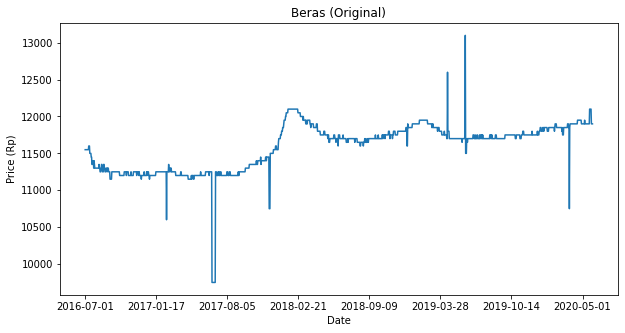

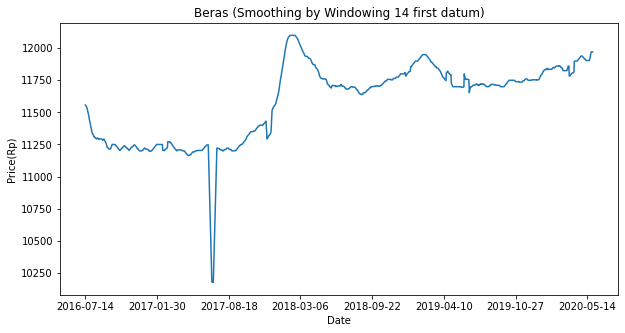

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Beras'] 

# Windowing
window = 14    # Estimated trend or cycles for better data and reduce noise (Moving Average Window)

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 8    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 50  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

In [0]:
#from sklearn.preprocessing import MinMaxScaler as MMS
#train,test = train_test_split(data_smooth,train_size=0.9)
#scale = MMS()
#train_sc = scale.fit_transform(train.values.reshape(-1,1))
#test_sc = scale.transform(test.values.reshape(-1,1))
#train_sc
#train_scale,test_scale,Min,Max = scale_val(train,test)
#train_scale
#train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
#                                                                    train_scale,test_scale)
#train_x

Length of Train and Test : (1274, 142)
Epoch 1/50
1266/1266 [==============================] - 28s 22ms/step - loss: 0.0114 - val_loss: 2.5547e-04
Epoch 2/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 3/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0022 - val_loss: 2.1543e-04
Epoch 4/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/50
1266/1266 [==============================] - 28s 22ms/step - loss: 0.0019 - val_loss: 2.1660e-04
Epoch 6/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0017 - val_loss: 1.6457e-04
Epoch 7/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0016 - val_loss: 7.5260e-04
Epoch 8/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0014 - val_loss: 2.0128e-04
Epoch 9/50
1266/1266 [==============================] - 27s 22ms/step - loss: 0.0012 - val_loss: 0.0021
E

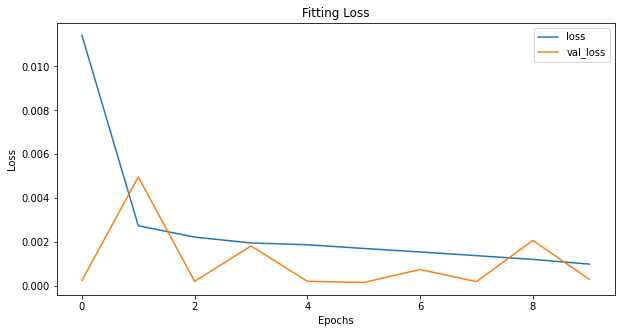

MAE : 204.74223898090335
Deviation of True Price and Prediction during validation is approximately 204.74 Rupiah


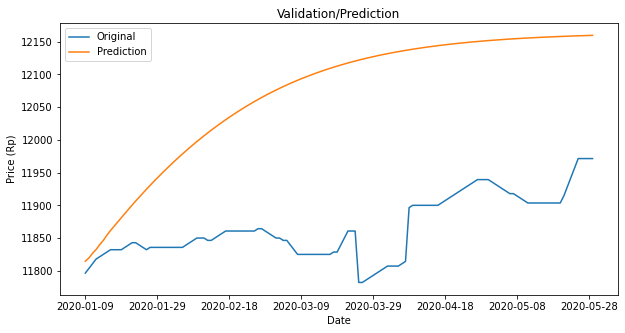

MAE : 560.737684827189
Price Deviation is approximately 560.74 Rupiah


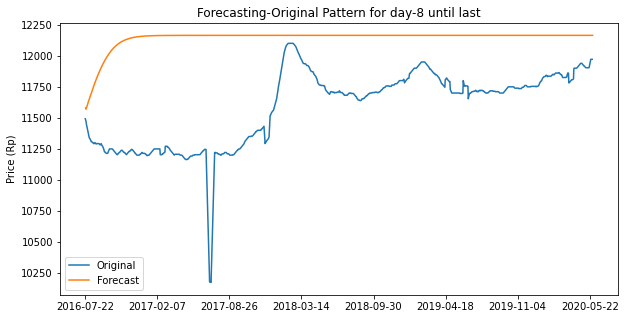

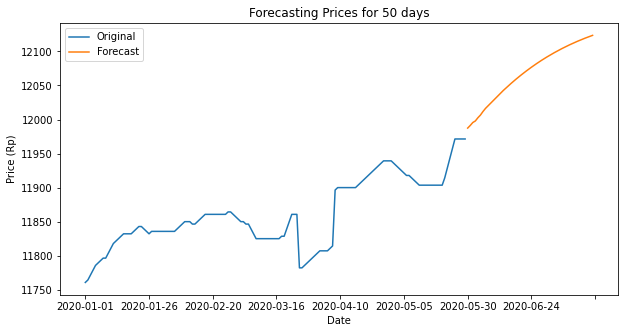

Not found flat-pattern-like in forecast result for 50 days
CPU times: user 7min 15s, sys: 54.3 s, total: 8min 9s
Wall time: 5min 14s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_beras  = dnn_model(train_x,optimizer='adam',loss='mse')
model_beras,loss_beras = train_model(model_beras,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_beras)

# Validation Phase
full_data_beras,error_beras,validation_beras = pred_val(length,model_beras,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_beras,mae_beras,predict_beras = pred_full(data_smooth,model_beras,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_beras,forecasting_beras = forecast(data_smooth,test_scale,model_beras,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# DAGING AYAM 

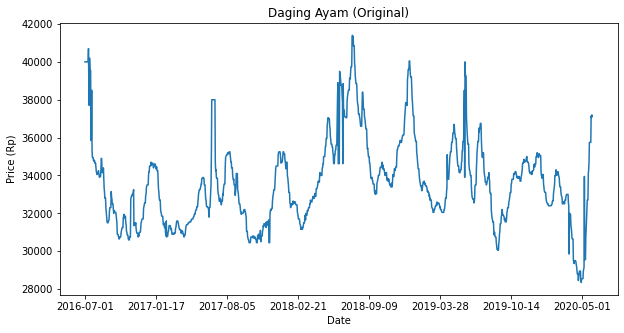

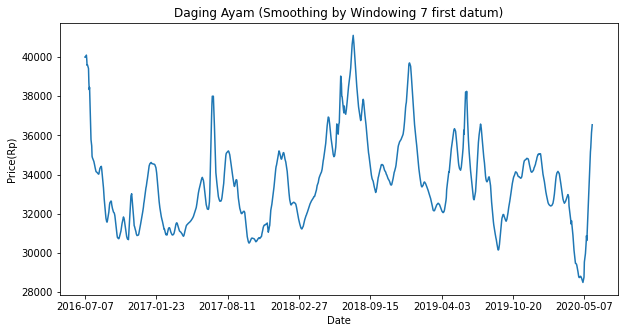

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Daging Ayam'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 7    # Moving Sequences (window_dataset in a week)
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 30  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1273/1273 [==============================] - 30s 24ms/step - loss: 0.0085 - val_loss: 0.0141
Epoch 2/50
1273/1273 [==============================] - 30s 23ms/step - loss: 0.0042 - val_loss: 0.0123
Epoch 3/50
1273/1273 [==============================] - 29s 23ms/step - loss: 0.0026 - val_loss: 0.0071
Epoch 4/50
1273/1273 [==============================] - 29s 23ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 5/50
1273/1273 [==============================] - 29s 23ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 6/50
1273/1273 [==============================] - 30s 23ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 7/50
1273/1273 [==============================] - 30s 23ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/50
1273/1273 [==============================] - 30s 23ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9/50
1273/1273 [==============================] - 29s 23ms/step - loss: 0.0014 - val_loss: 8.4762e-04
Epoch 10/50
1273/1273

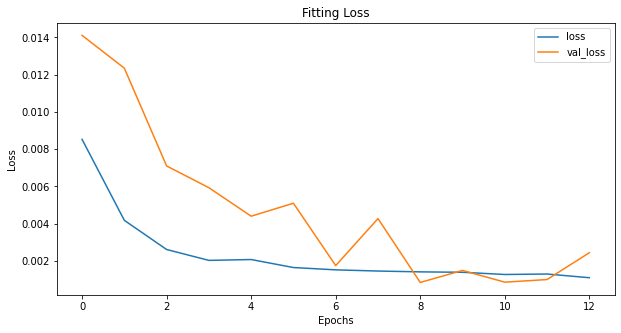

MAE : 1773.1551512130552
Deviation of True Price and Prediction during validation is approximately 1773.16 Rupiah


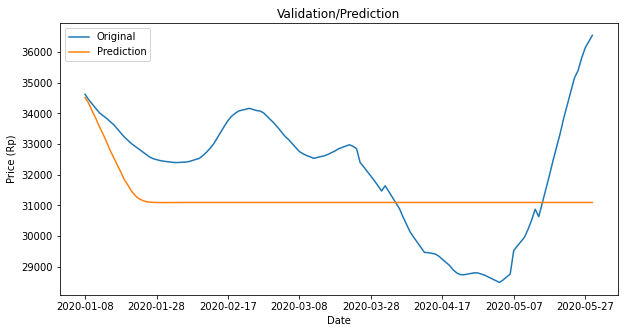

MAE : 3928.840354834086
Price Deviation is approximately 3928.84 Rupiah


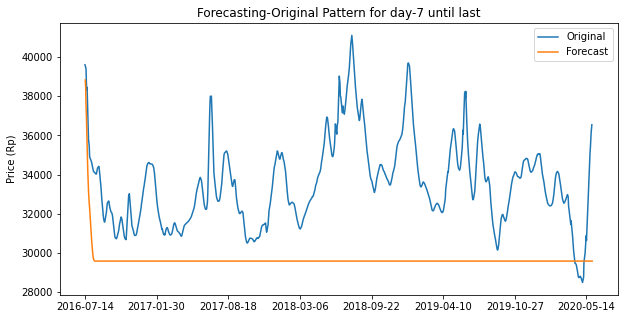

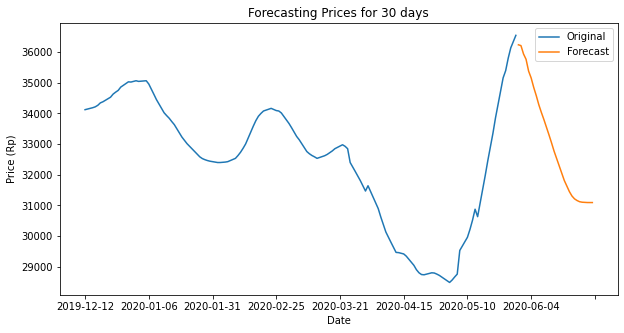

Limit days for pattern-like forecasting (not-flat) is 7 days
CPU times: user 9min 49s, sys: 1min 13s, total: 11min 2s
Wall time: 7min 4s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_ayam  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_ayam,loss_ayam = train_model(model_ayam,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_ayam)

# Validation Phase
full_data_ayam,error_ayam,validation_ayam = pred_val(length,model_ayam,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_ayam,mae_ayam,predict_ayam = pred_full(data_smooth,model_ayam,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_ayam,forecasting_ayam = forecast(data_smooth,test_scale,model_ayam,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# GULA PASIR

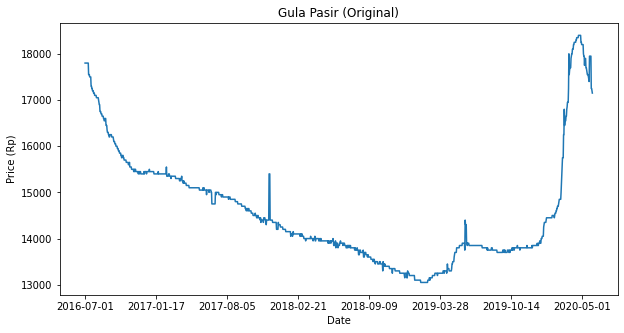

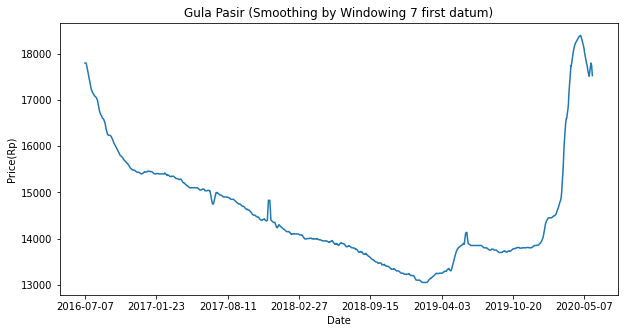

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Gula Pasir'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
  ...
    to  
  ['...']
Train for 1270 steps, validate for 133 steps
Epoch 1/50
1270/1270 [==============================] - 19s 15ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 2/50
1270/1270 [==============================] - 15s 12ms/step - loss: 0.0010 - val_loss: 0.0090
Epoch 3/50
1270/1270 [==============================] - 15s 12ms/step - loss: 7.4093e-04 - val_loss: 0.0059
Epoch 4/50
1270/1270 [==============================] - 15s 12ms/step - loss: 6.5764e-04 - val_loss: 0.0054
Epoch 5/50
1270/1270 [==============================] - 15s 12ms/step - loss: 5.5687e-04 - val_loss: 0.0109
Epoch 6/50
1270/1270 [==============================] - 15s 12ms/step - loss: 4.8671e-04 - val_loss: 0.0150


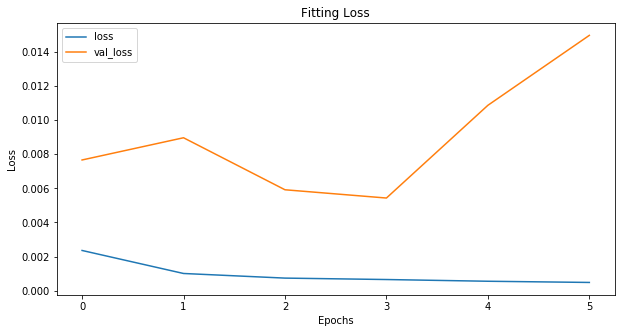

MAE : 2525.227832183852
Deviation of True Price and Prediction during validation is approximately 2525.23 Rupiah


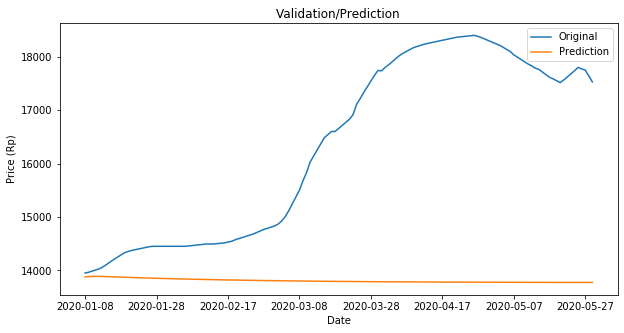

MAE : 795.0713595115353
Price Deviation is approximately 795.07 Rupiah


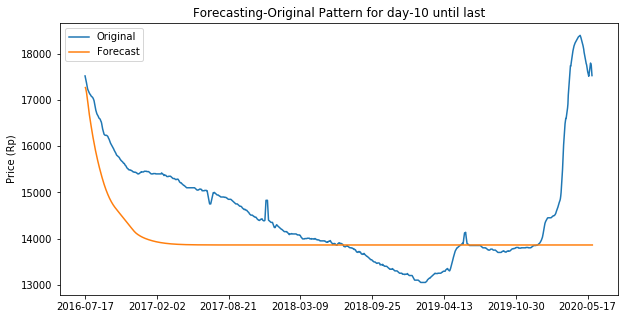

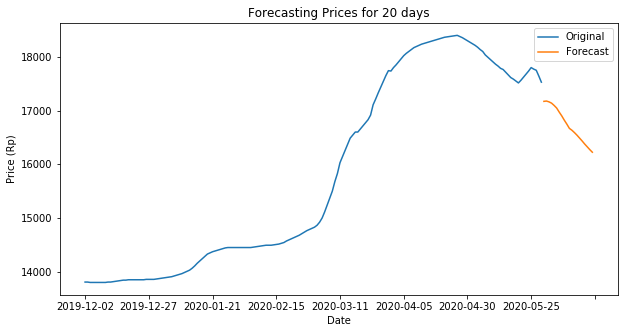

Limit days for pattern-like forecasting (not-flat) is 8 days
Wall time: 2min 25s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_gula  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_gula,loss_gula = train_model(model_gula,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_gula)

# Validation Phase
full_data_gula,error_gula,validation_gula = pred_val(length,model_gula,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_gula,mae_gula,predict_gula = pred_full(data_smooth,model_gula,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_gula,forecasting_gula = forecast(data_smooth,test_scale,model_gula,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# BAWANG PUTIH

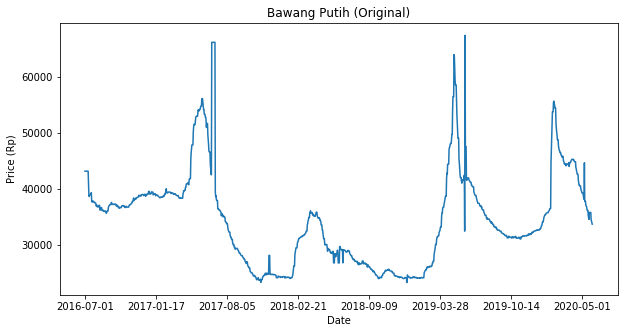

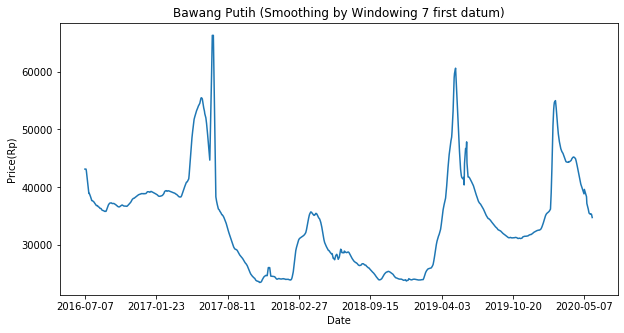

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Bawang Putih'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1270 steps, validate for 133 steps
Epoch 1/50
1270/1270 [==============================] - 33s 26ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 2/50
1270/1270 [==============================] - 21s 17ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 3/50
1270/1270 [==============================] - 21s 17ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 4/50
1270/1270 [==============================] - 22s 17ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/50
1270/1270 [==============================] - 22s 18ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 6/50
1270/1270 [==============================] - 22s 17ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 7/50
1270/1270 [==============================] - 22s 17ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/50
1270/1270 [==============================] - 23s 18ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/50
1270/1270 [============

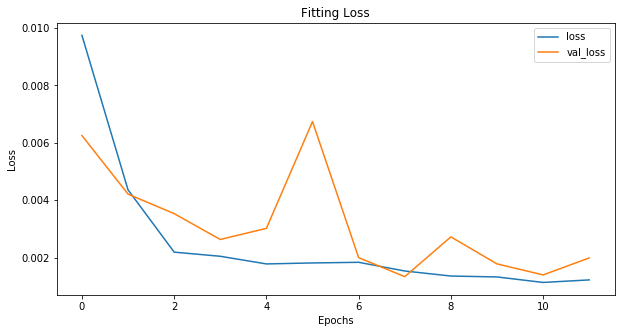

MAE : 18004.331521092023
Deviation of True Price and Prediction during validation is approximately 18004.33 Rupiah


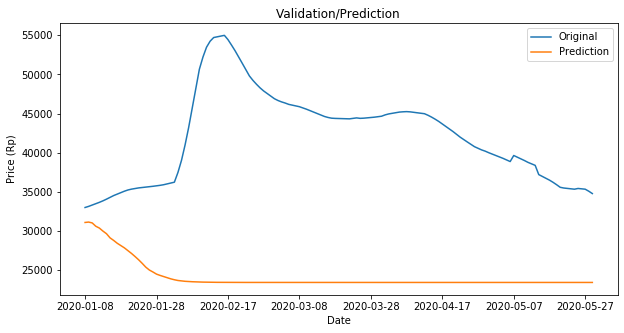

MAE : 10565.828878307206
Price Deviation is approximately 10565.83 Rupiah


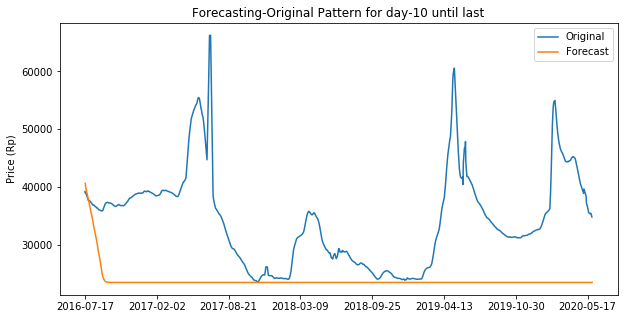

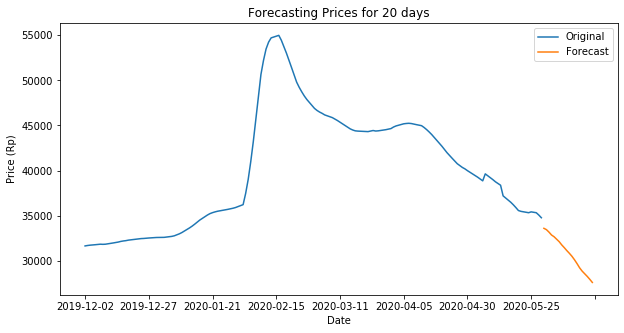

Limit days for pattern-like forecasting (not-flat) is 7 days
Wall time: 6min 49s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_bp  = dnn_model(train_x,optimizer='adam',loss='mse')
model_bp,loss_bp = train_model(model_bp,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_bp)

# Validation Phase
full_data_bp,error_bp,validation_bp = pred_val(length,model_bp,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_bp,mae_bp,predict_bp = pred_full(data_smooth,model_bp,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_bp,forecasting_bp = forecast(data_smooth,test_scale,model_bp,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# BAWANG MERAH

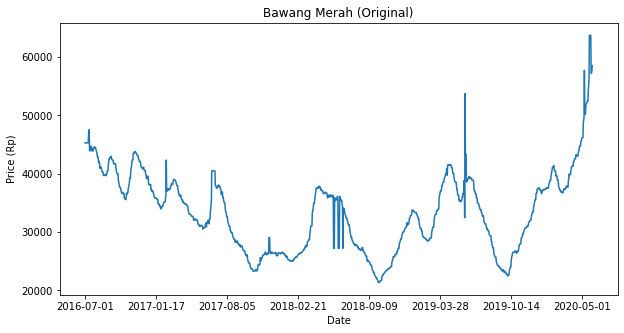

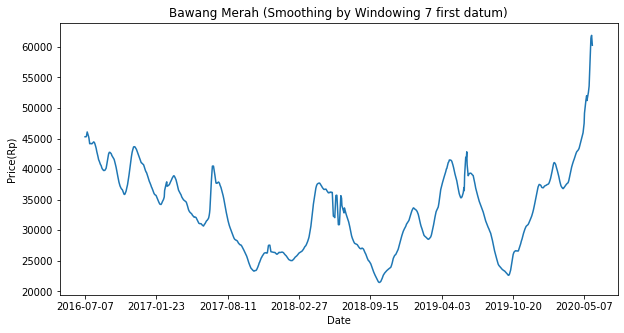

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Bawang Merah'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0095 - val_loss: 0.0537
Epoch 2/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 3/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 5/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 6/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0021 - val_loss: 0.0104
Epoch 7/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0020 - val_loss: 0.0049


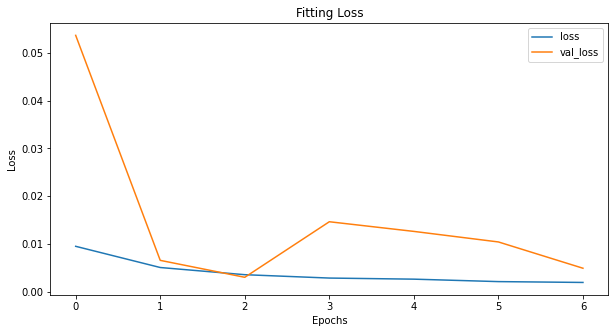

MAE : 7399.067782355352
Deviation of True Price and Prediction during validation is approximately 7399.07 Rupiah


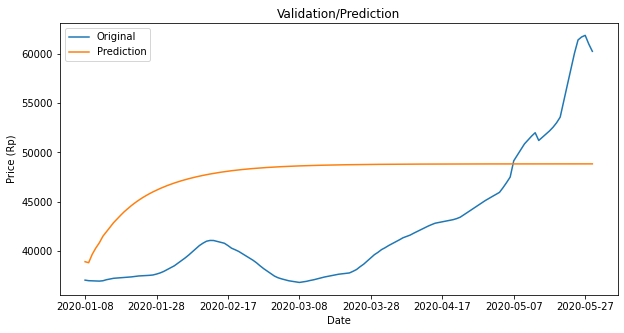

MAE : 32924.82188700629
Price Deviation is approximately 32924.82 Rupiah


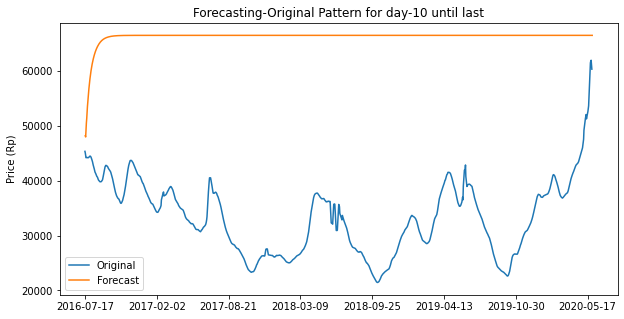

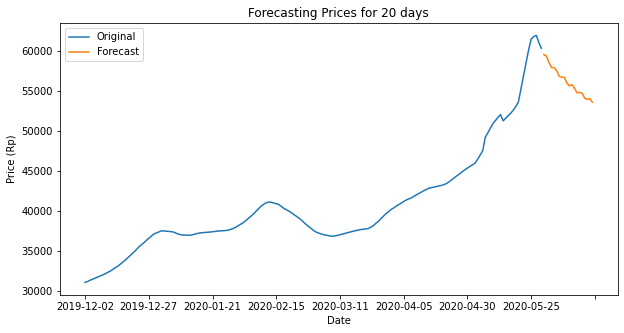

Limit days for pattern-like forecasting (not-flat) is 7 days
CPU times: user 6min 48s, sys: 49.3 s, total: 7min 37s
Wall time: 4min 56s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_bm  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_bm,loss_bm = train_model(model_bm,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_bm)

# Validation Phase
full_data_bm,error_bm,validation_bm = pred_val(length,model_bm,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_bm,mae_bm,predict_bm = pred_full(data_smooth,model_bm,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_bm,forecasting_bm = forecast(data_smooth,test_scale,model_bm,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# DAGING SAPI

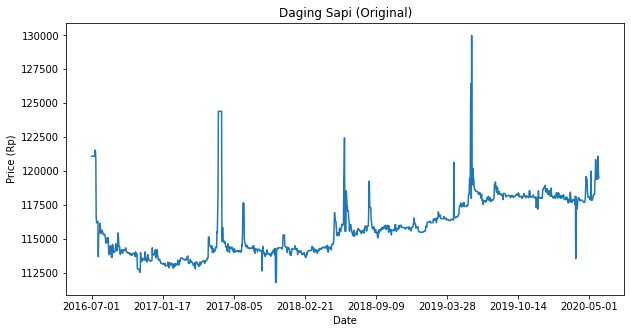

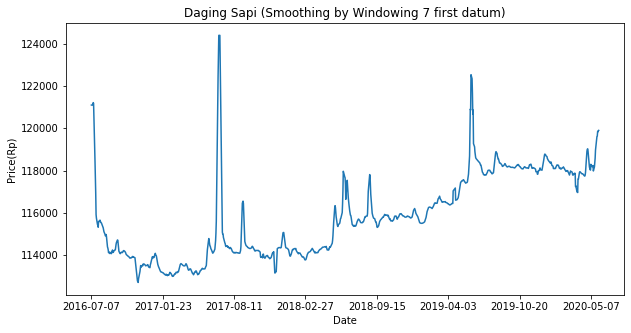

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Daging Sapi'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0099 - val_loss: 0.0012
Epoch 2/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0048 - val_loss: 0.0263
Epoch 3/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0037 - val_loss: 5.9425e-04
Epoch 4/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0029 - val_loss: 4.7699e-04
Epoch 5/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0026 - val_loss: 4.8411e-04
Epoch 6/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0021 - val_loss: 9.8461e-04
Epoch 7/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0018 - val_loss: 4.9685e-04


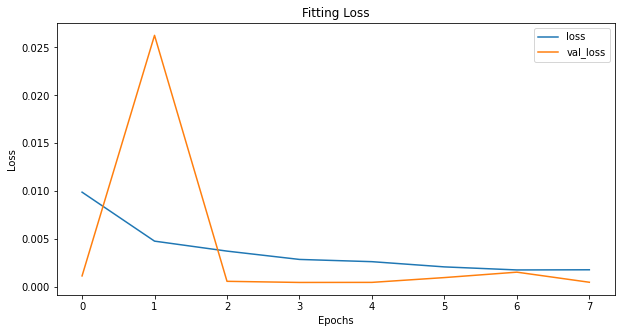

MAE : 588.3778471749021
Deviation of True Price and Prediction during validation is approximately 588.38 Rupiah


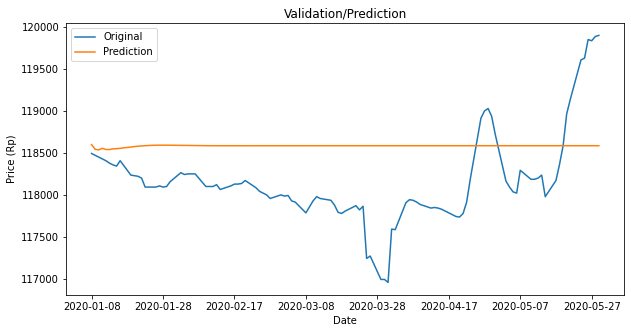

MAE : 2889.011045060159
Price Deviation is approximately 2889.01 Rupiah


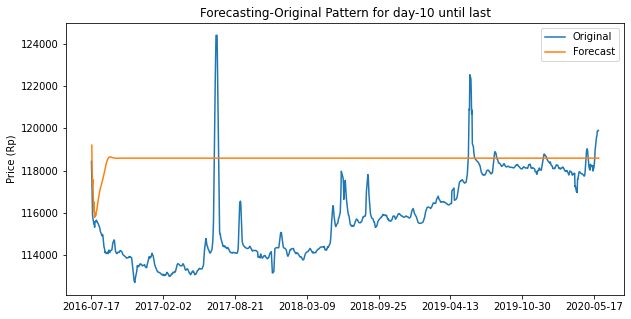

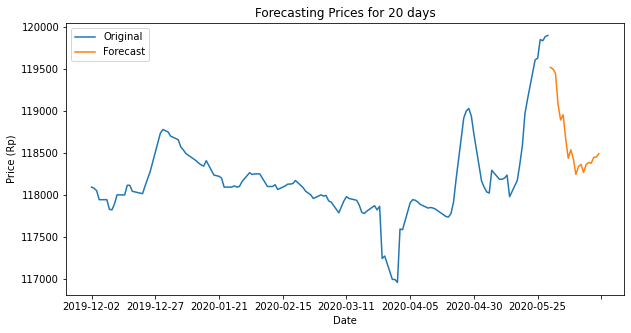

Limit days for pattern-like forecasting (not-flat) is 8 days
CPU times: user 7min 42s, sys: 56 s, total: 8min 38s
Wall time: 5min 34s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_sapi  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_sapi,loss_sapi = train_model(model_sapi,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_sapi)

# Validation Phase
full_data_sapi,error_sapi,validation_sapi = pred_val(length,model_sapi,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_sapi,mae_sapi,predict_sapi = pred_full(data_smooth,model_sapi,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_sapi,forecasting_sapi = forecast(data_smooth,test_scale,model_sapi,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# TELUR AYAM

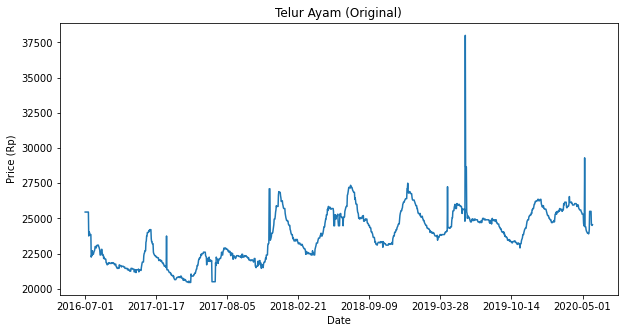

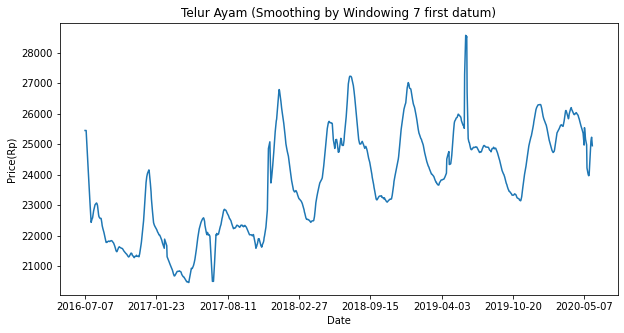

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Telur Ayam'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0139 - val_loss: 0.0065
Epoch 2/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 3/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0038 - val_loss: 9.4745e-04
Epoch 4/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 7/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0021 - val_loss: 8.6132e-04
Epoch 8/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0017 - val_loss: 7.8406e-04
Epoch 10/50
1

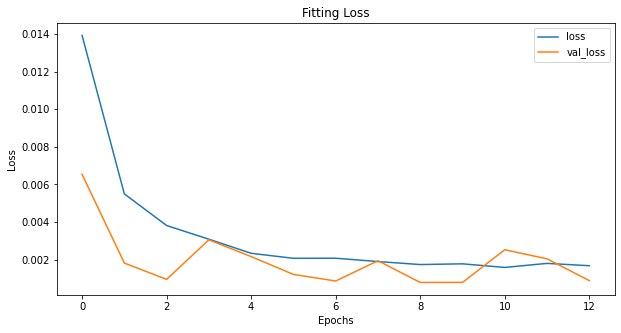

MAE : 956.0526284780889
Deviation of True Price and Prediction during validation is approximately 956.05 Rupiah


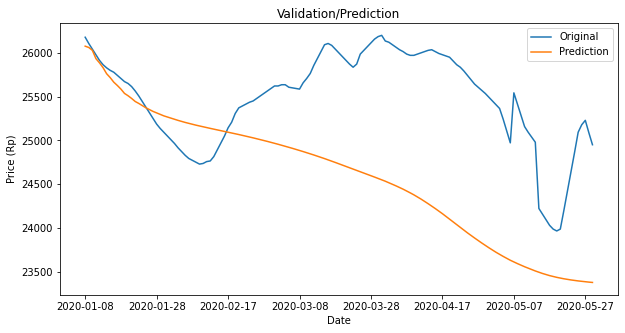

MAE : 1527.3736505563077
Price Deviation is approximately 1527.37 Rupiah


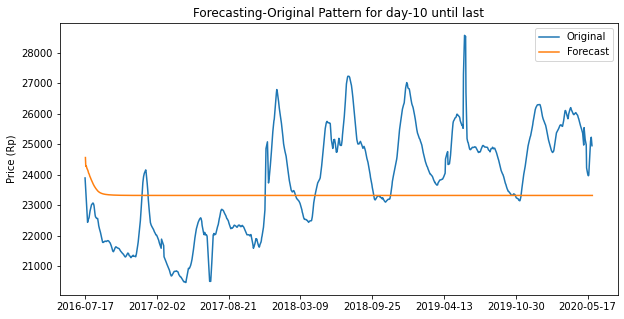

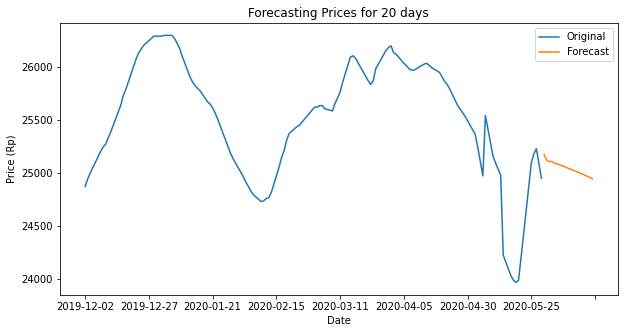

Limit days for pattern-like forecasting (not-flat) is 8 days
CPU times: user 12min 2s, sys: 1min 30s, total: 13min 32s
Wall time: 8min 35s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_telur  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_telur,loss_telur = train_model(model_telur,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_telur)

# Validation Phase
full_data_telur,error_telur,validation_telur = pred_val(length,model_telur,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_telur,mae_telur,predict_telur = pred_full(data_smooth,model_telur,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_telur,forecasting_telur = forecast(data_smooth,test_scale,model_telur,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# MINYAK GORENG

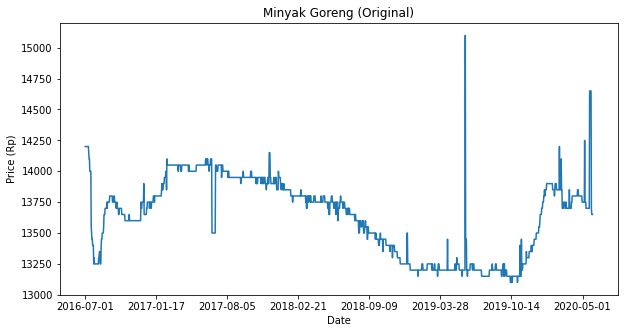

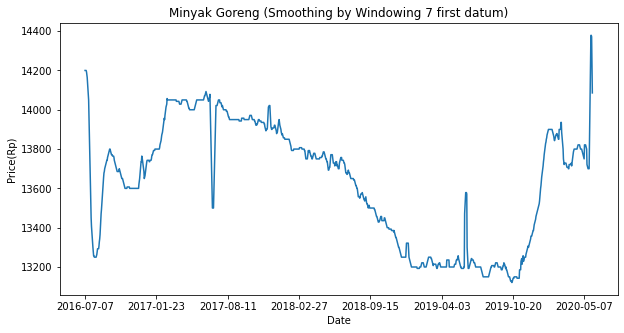

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Minyak Goreng'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0129 - val_loss: 0.0114
Epoch 2/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0070 - val_loss: 0.0094
Epoch 3/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0045 - val_loss: 0.0154
Epoch 4/50
1270/1270 [==============================] - 36s 28ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 5/50
1270/1270 [==============================] - 36s 28ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 6/50
1270/1270 [==============================] - 36s 28ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 7/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0025 - val_loss: 0.0066
Epoch 8/50
1270/1270 [==============================] - 36s 28ms/step - loss: 0.0024 - val_loss: 0.0053
Epoch 9/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 10/50
1270/1270 [==

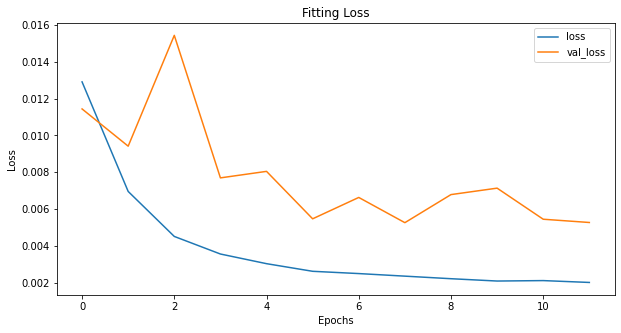

MAE : 377.22316108472853
Deviation of True Price and Prediction during validation is approximately 377.22 Rupiah


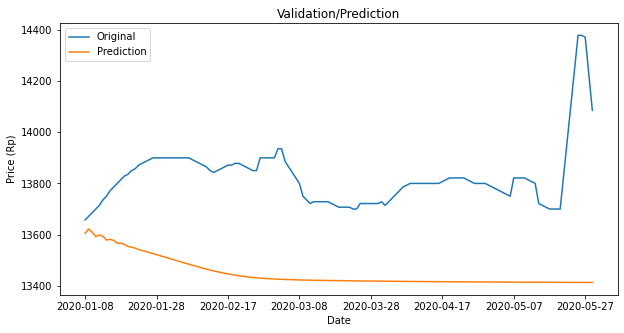

MAE : 548.1085476457343
Price Deviation is approximately 548.11 Rupiah


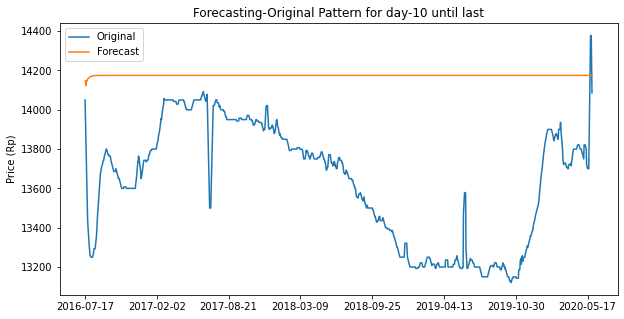

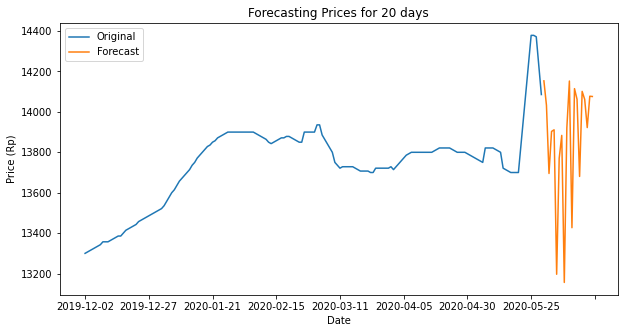

Limit days for pattern-like forecasting (not-flat) is 14 days
CPU times: user 11min 8s, sys: 1min 22s, total: 12min 31s
Wall time: 7min 57s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_minyak  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_minyak,loss_minyak = train_model(model_minyak,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_minyak)

# Validation Phase
full_data_minyak,error_minyak,validation_minyak = pred_val(length,model_minyak,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_minyak,mae_minyak,predict_minyak = pred_full(data_smooth,model_minyak,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_minyak,forecasting_minyak = forecast(data_smooth,test_scale,model_minyak,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# CABAI MERAH

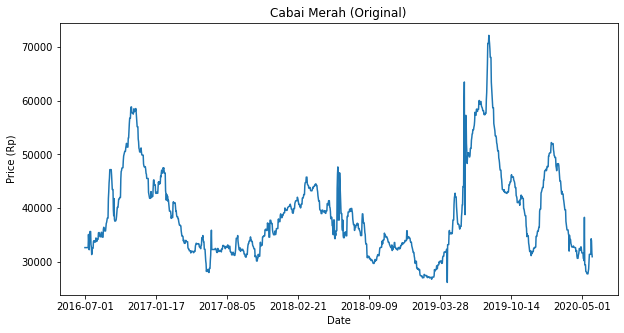

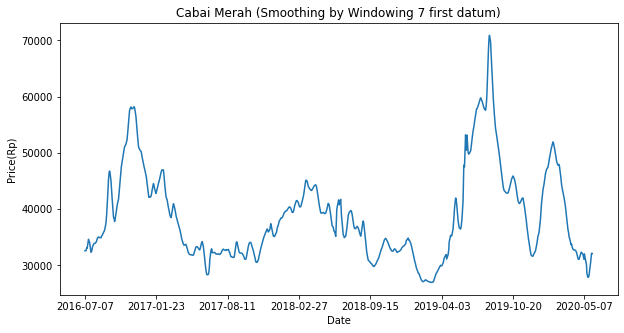

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Cabai Merah'] 

# Windowing
window = 7    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1280, 143)
Epoch 1/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0078 - val_loss: 0.0024
Epoch 2/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 3/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0027 - val_loss: 8.3678e-04
Epoch 4/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 6/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0017 - val_loss: 9.1678e-04
Epoch 7/50
1270/1270 [==============================] - 37s 29ms/step - loss: 0.0018 - val_loss: 7.6083e-04
Epoch 8/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0014 - val_loss: 5.9828e-04
Epoch 9/50
1270/1270 [==============================] - 36s 29ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 10/

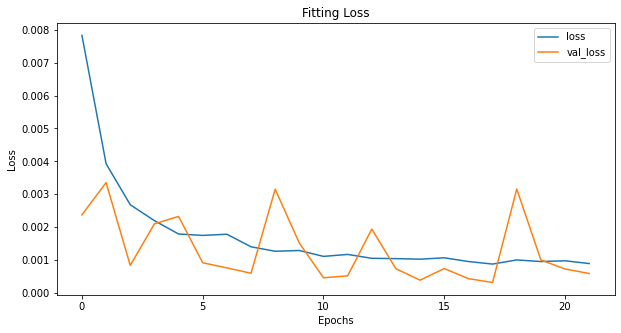

MAE : 7597.71041570568
Deviation of True Price and Prediction during validation is approximately 7597.71 Rupiah


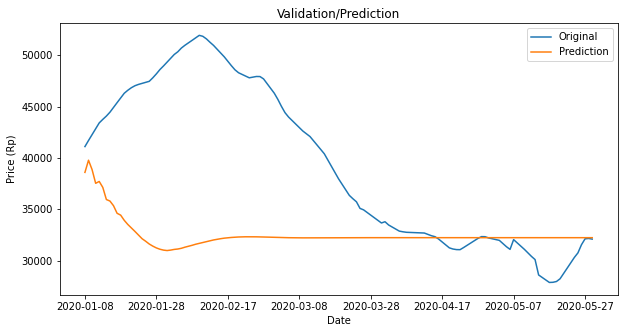

MAE : 7340.988763459889
Price Deviation is approximately 7340.99 Rupiah


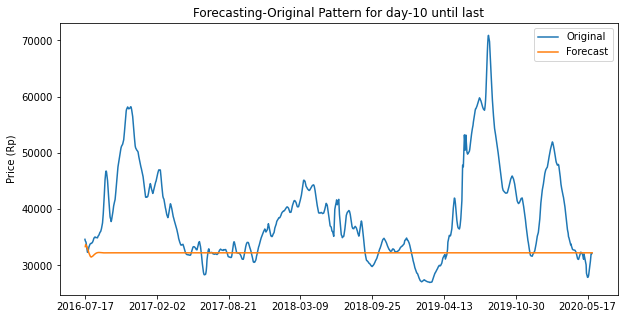

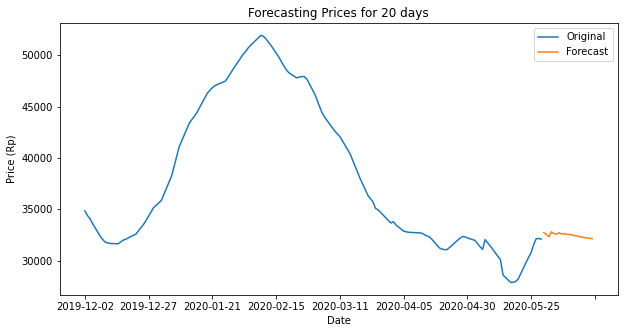

Limit days for pattern-like forecasting (not-flat) is 10 days
CPU times: user 19min 54s, sys: 2min 31s, total: 22min 26s
Wall time: 14min 4s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_cabmer  = dnn_model(train_x,optimizer='RMSprop',loss='mse')
model_cabmer,loss_cabmer = train_model(model_cabmer,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_cabmer)

# Validation Phase
full_data_cabmer,error_cabmer,validation_cabmer = pred_val(length,model_cabmer,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_cabmer,mae_cabmer,predict_cabmer = pred_full(data_smooth,model_cabmer,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_cabmer,forecasting_cabmer = forecast(data_smooth,test_scale,model_cabmer,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# CABAI RAWIT

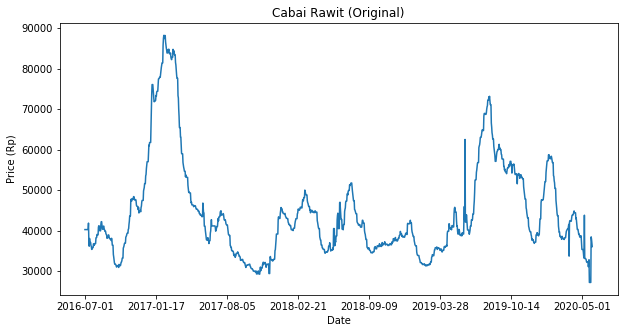

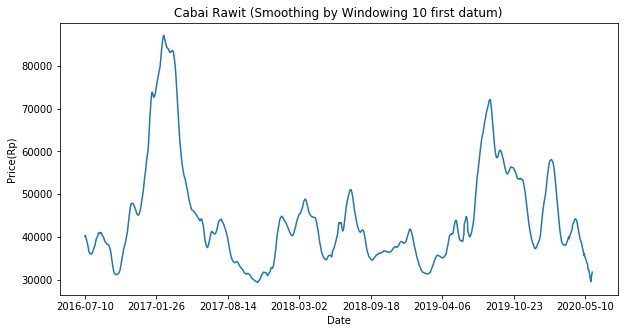

In [0]:
## HYPERPARAMETER SETTING (Changeably parameter except noted by "Don't Change") and SUBDATA DEFINING

# Subdata 
data = df['Cabai Rawit'] 

# Windowing
window = 10    # Estimated trend or cycles for better data and reduce noise

# Splitting Portion
train_size = 0.9  # Percentage of train dataset (in range 0-1)

# Single-Step Training and Validation (batch_size = 1)
length  = 10    # Moving Sequences 
output  = 1    # Prediction/Output every steps (Don't Change!) 

# Training
wait_order = 4  # Do some iteration after get optimal value (look for more optimal value if exists)
epochs     = 50 # Iterations when fitting.

# Forecasting
forward  = 20  # How far prediction days from last date in data. 

# Plotting dataset first
data_smooth = plot_window(data,window)  # Plot and get smoothed data

Length of Train and Test : (1278, 142)
  ...
    to  
  ['...']
Train for 1268 steps, validate for 132 steps
Epoch 1/50
1268/1268 [==============================] - 22s 18ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 2/50
1268/1268 [==============================] - 18s 14ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 3/50
1268/1268 [==============================] - 18s 14ms/step - loss: 0.0017 - val_loss: 6.8330e-04
Epoch 4/50
1268/1268 [==============================] - 17s 13ms/step - loss: 0.0010 - val_loss: 1.4029e-04
Epoch 5/50
1268/1268 [==============================] - 17s 14ms/step - loss: 8.0053e-04 - val_loss: 0.0010
Epoch 6/50
1268/1268 [==============================] - 19s 15ms/step - loss: 6.1885e-04 - val_loss: 3.1291e-04
Epoch 7/50
1268/1268 [==============================] - 17s 13ms/step - loss: 5.9710e-04 - val_loss: 1.5585e-04
Epoch 8/50
1268/1268 [==============================] - 17s 14ms/step - loss: 5.0472e-04 - val_loss: 4.5014e-05
Epoch 9/50
1268/1268 [=

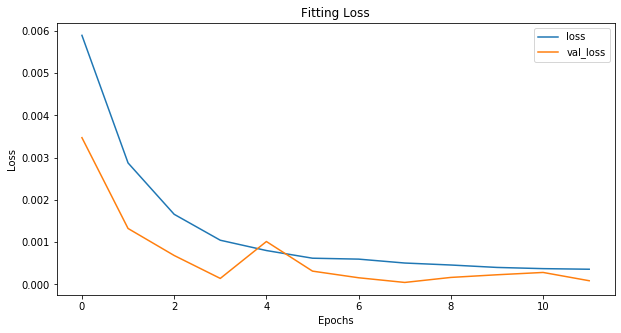

MAE : 11079.454494809968
Deviation of True Price and Prediction during validation is approximately 11079.45 Rupiah


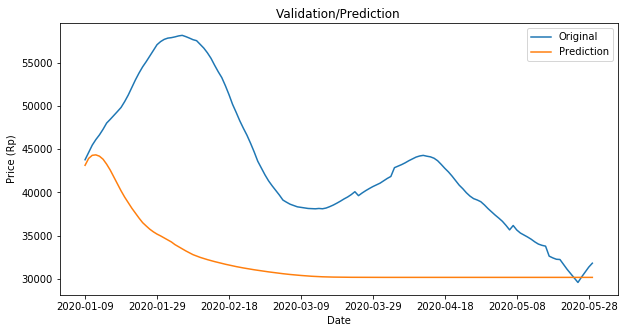

MAE : 14170.964358992742
Price Deviation is approximately 14170.96 Rupiah


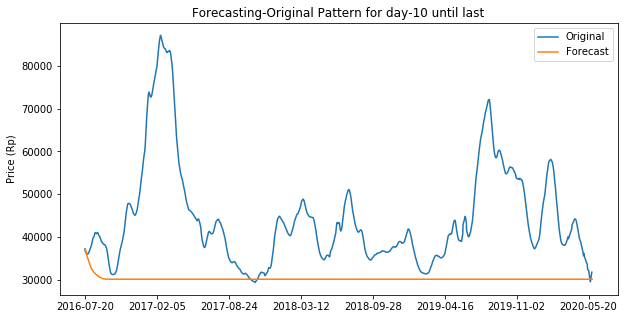

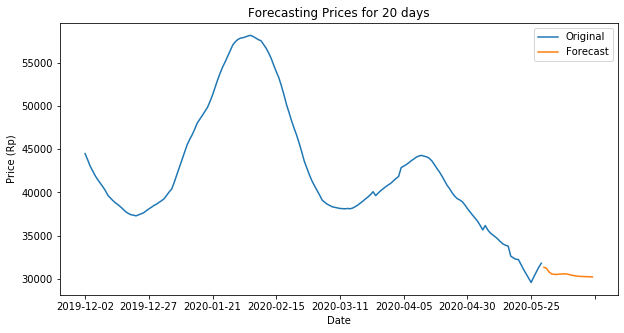

Limit days for pattern-like forecasting (not-flat) is 10 days
Wall time: 4min 32s


In [0]:
%%time

## SPLIT , BUILD, TRAIN, VALIDATION/PREDICTION, AND FORECAST
# (Use this code-line to make trial and error with only change of some part such as optimizer,limit,model_name)

# Splitting and Scaling (Please use data_smooth for better result)
train,test                     = train_test_split(data_smooth,train_size) 
train_scale,test_scale,Min,Max = scale_val(train,test)

# Use train/test scale instead of train/test for better result
train_x,train_y,test_x,test_y,train_gen,val_gen = prepare_generator(length,output,
                                                                    train_scale,test_scale)
model_cabwit  = dnn_model(train_x,optimizer='RMSprop')
model_cabwit,loss_cabwit = train_model(model_cabwit,train_gen,val_gen,wait_order=wait_order,epochs=epochs)
plot_loss(loss_cabwit)

# Validation Phase
full_data_gula,error_cabwit,validation_cabwit = pred_val(length,model_cabwit,test_scale,train_scale,Min,Max)

# Forecasting Original Data (reduced by length) (Please use data_smooth for better result)
result_cabwit,mae_cabwit,predict_cabwit = pred_full(data_smooth,model_cabwit,length=length)

# Forecasting Beyond (Please use data_smooth for better result)
all_data_cabwit,forecasting_cabwit = forecast(data_smooth,test_scale,model_cabwit,length,Min=Min,Max=Max,fore_days=forward,limit=True)

# Basemodel is available (from Coursera with name "BASEMODEL_UNIVARIATE.ipynb")

## CONCLUSIONS
1. Fitting takes approximately under 20 iterations and 3 minutes to get optimum losses
2. Validation loss (mse) is approximately good under 1.
3. MAE (or we could call it as absolute difference between true and prediction) is relatively small. This is good due to average price deviation.
4. MAE in validation phase is useful for quick look but for determining uncertainties in price prediction, It is better to use MAE pred_full due to predicting almost dataset (if MAE pred_full is not nan or infinity).
5. Forecasting values seems follow similar pattern with close previous data.
6. Limit for getting pattern-like future values is available in code. This limit approach help us to take early forecasting trusty.In other means,number of days of forecast which still give good enough result.
7. At first trial, this model outperforms basemodel which this model's mae is about 267 and basemodel's mae is 688 (after dataset windowing).
8. Basemodel don't performs forecasting beyond dataset because validation results is not satisfying (they just flat/constant values) but this model gives varying results which have fluctuative pattern so the model is worthy to bring forecasting and it's forecasting almost follow certain closest data pattern.
9. Running time in basemodel is about 4 minutes but this model just take about 2 minutes (almost 2 times faster with complex layer added).
9. Finally, at general and first observation, this model is better than basemodel at metrics(mae),pattern-prediction,operations(early stopping and converge loss), and execution time.  

## IMPROVISATIONS
1. Get into data transformation and smoothing like power transformation or Kernel RBF. Maybe this will get better result.
2. Combination of more Conv1D,MaxPool1D,and LSTM for better chances to identify the pattern.
3. Define window (length parameter) based on seasonality and trend viewed when price is greatly change or from daily market.  
4. Hyperparameter setting such as window, wait_order, train_size, length, metrics, and fore_days.